# Time Series Classification (TSC) exploration with LSTM and Convolutional Neural Networks

*This notebook is meant to be an initial exporation of time series classification for me. As this is one of my first notebooks and the subject matter is new to me, any feedback would be much appreciated!*

## Exploratory data analysis

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
train = pd.read_csv('/kaggle/input/heartbeat/mitbih_train.csv',header=None)
test = pd.read_csv('/kaggle/input/heartbeat/mitbih_test.csv',header=None)

In [ ]:
print(train.shape)
print(test.shape)

So the training and testing data are timeseries of 187 timepoints, with the 188th as the ground truth class of heartbeat

In [ ]:
#plot first for training heartbeats. Each heartbeat is 188 long.
import matplotlib.pyplot as plt

plt.subplot(2,2,1)
plt.plot(train.iloc[0,:186])

plt.subplot(2,2,2)
plt.plot(train.iloc[1,:186])

plt.subplot(2,2,3)
plt.plot(train.iloc[2,:186])

plt.subplot(2,2,4)
plt.plot(train.iloc[3,:186])

print(train[187][0], train[187][1], train[187][2], train[187][3])

Here we graph the first four training heartbeats to get a sense of how the timeseries data looks. We see that the hearbeats are all 187 units longs, and each of the beats plotted are normal hearbeats. This tells us that amplitude and location of the QRS spike, as well as P and T wave patterns can vary between samples.

Standard Heartbeat image for reference:
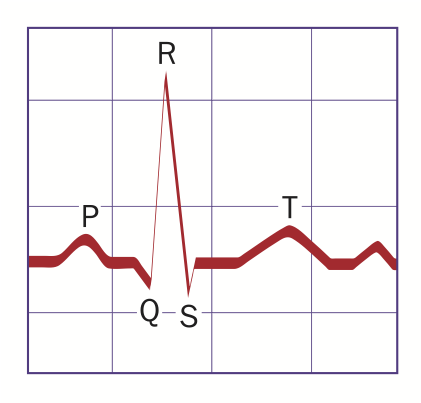

Let's look at the distribution of classes in the training set:

In [ ]:
print(train[187].value_counts())

There are way more normal beats than any other class of arrythmia, so we will downsample (make class distrubtion even) shortly.

Visualization of the 5 different Arrythmia Class Types

In [ ]:
f, axs = plt.subplots(5,1,figsize=(5,10))

plt.subplot(5,1,1)
plt.ylabel("Normal")
plt.ylim(0,1)
plt.plot(train.loc[train[187] == 0.0].loc[0])

plt.subplot(5,1,2)
plt.ylabel("Supraventricular Premature")
plt.ylim(0,1)
plt.plot(train.loc[train[187] == 1.0].loc[72471])

plt.subplot(5,1,3)
plt.ylabel("Premature VC")
plt.ylim(0,1)
plt.plot(train.loc[train[187] == 2.0].loc[74694])

plt.subplot(5,1,4)
plt.ylabel("Fusion")
plt.ylim(0,1)
plt.plot(train.loc[train[187] == 3.0].loc[80482])

plt.subplot(5,1,5)
plt.ylabel("Unclassifiable Beat")
plt.ylim(0,1)
plt.plot(train.loc[train[187] == 4.0].loc[81123])

* 0: Normal beat
* 1: Supraventricular premature beat
* 2: Premature ventricular contraction
* 3: Fusion of ventricular and normal beat
* 4: Unclassifiable beat

Again, while there are distinct differences between the hearbeats, there are definetely similarities between some of the classes that could result in misclassification.

Interpolation is already taken care of for this data set... let's downsample target data for multiclassification.
> Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188. 


In [ ]:
train_target = train[187]
label= 187

df = train.groupby(label, group_keys=False)
train = pd.DataFrame(df.apply(lambda x: x.sample(df.size().min()))).reset_index(drop=True)

In [ ]:
print(train[187].value_counts())

Now there is an equal number of each class in our training set.

### One hot encoding for categorical target

Since we will be using neural networks for our classification model, our output classes need to be turned into a numerical representation. We use one hot encoding (from sklearn package) to do this.

In [ ]:
train_target = train[187]
train_target = train_target.values.reshape(3205,1)
#one hot encode train_target

from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
# TODO: create a OneHotEncoder object, and fit it to all of X

# 1. INSTANTIATE
enc = preprocessing.OneHotEncoder()

# 2. FIT
enc.fit(train_target)

# 3. Transform
onehotlabels = enc.transform(train_target).toarray()
onehotlabels.shape

target = onehotlabels

Now our classes change from "0", "1", etc. to a vector of 0s and 1s shown below.

In [ ]:
print(target[0])

To train my neural network I want to split up my training data into a training set and validation set. Training data will be fed to our model so that it can learn how to classify the arrythmias, while validation data will be used to test the accuracy of the classifier. I will also test against test data separately.

I also want to separate the ground truth labels from the training data at this point.
1. remove ground truth labels from training df
2. train/test split

In [ ]:
from sklearn.model_selection import train_test_split

X = train
X = X.drop(axis=1,columns=187)

X_train, X_valid, Y_train, Y_valid = train_test_split(X,target, test_size = 0.25, random_state = 36)

In [ ]:
X_train = np.asarray(X_train)
X_valid = np.asarray(X_valid)
Y_train = np.asarray(Y_train)
Y_valid = np.asarray(Y_valid)

#X_train.reshape((1, 2403, 187))
X_train = np.expand_dims(X_train, axis=2)
X_valid = np.expand_dims(X_valid, axis=2)
print(X_train.shape)
print(Y_train.shape)

So we have 2,403 training heartbeats and 802 validation heartbeats for a 75:25 train-test split. Let's move on to building our classifier.

# Naive LSTM setup

*Utility function for tracking model loss and accuracy per epoch*

In [ ]:
#1. Function to plot model's validation loss and validation accuracy
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## What is an LSTM?

Recurrent Neural networks contain nodes of the network that feed back to themselves. This can essentially ellicit a representation of "memory" in the network that makes them extremely useful for sequence data such as natural language processessing, timeseries data and genomic data.

Recurrent Neural networks can be vulnerable to the vanishing gradient problem and not be able to use context from further in the past (or something it had encountered at the very beginning of a document, for example). LSTMs are a type of Recurrent neural network that get around the vanishing gradient problem by using an additive function within its "memory unit". 
<img src="https://colah.github.io/images/post-covers/lstm.png" width="400"/>

(you can read more about them here: https://towardsdatascience.com/understanding-lstm-and-its-quick-implementation-in-keras-for-sentiment-analysis-af410fd85b47)

### Define our LSTM network via Keras package

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Activation

model = Sequential()
#hidden layers is Ni + No * (2/3) -> 187 + 5 *(2/3) = 128
model.add(LSTM(128, input_shape=(187, 1), dropout=0.2, recurrent_dropout=0.2,return_sequences=True))
model.add(Flatten())
model.add(Dense(5, activation='softmax')) #output of 5 potential encodings
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 15
batch_size = 1

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)

Number of Hidden layers heuristic from: https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm
I played around with this and got similar results from 100 - 128 units.

In [ ]:
Y_pred = model.predict(X_valid)

#Converting predictions to label
pred = list()
for i in range(len(Y_pred)):
    pred.append(np.argmax(Y_pred[i]))
#Converting one hot encoded test label to label
test = list()
for i in range(len(Y_valid)):
    test.append(np.argmax(Y_valid[i]))

In [ ]:
from sklearn.metrics import accuracy_score
a = accuracy_score(pred,test)
print('Accuracy is:', a*100)

To concretely show how our network classifies a heartbeat, we take a randomly generated index of the validation set and print out both the predicted and ground truth class. (This may or may not match since our accuracy is somewhat low)

In [ ]:
import random

rand_ind = random.randint(0,802)
print(rand_ind)
plt.plot(X_valid[rand_ind,:,:])

class_dict = {0: "normal", 1: "Supraventricular Premature Beat", 2: "Premature ventricular contraction", 3:"Fusion of ventricular and normal beat", 4:"Unclassifiable beat"}

print("Predicted class: ", class_dict[pred[rand_ind]])
print("Actual class: ", class_dict[test[rand_ind]])

# Image Encoding - a computer vision approach 

From: 
1. [Wang and Oates et al. 2015] Zhiguang Wang and Tim Oates. **Imaging Time-Series to Improve Classification and Imputation.** In In Proceedings of the 24th International Conference on Artificial Intelligence (IJCAI'15), AAAI Press 3939-3945. https://arxiv.org/pdf/1506.00327.pdf 
2. **"Encoding Time Series as Images for Visual Inspection and Classification Using Tiled Convolutional Neural Networks." **
Wang, Zhiguang, and Tim Oates. 
In Workshops at the Twenty-Ninth AAAI Conference on Artificial Intelligence. 2015.



Because many advances in deep learning have been made in the context of image classification, if we can somehow encode our timeseries data as an image, we could use convolutional neural networks and potentially increas classification accuracy. 

We use Gramian Angular Summation Fields (GASF), Gramian Angular Difference Fields (GADF) and Markov Transition Fields (MTF) to encode the time series as images. 

While the paper feeds these into Tiled Convolutional Neural Nets 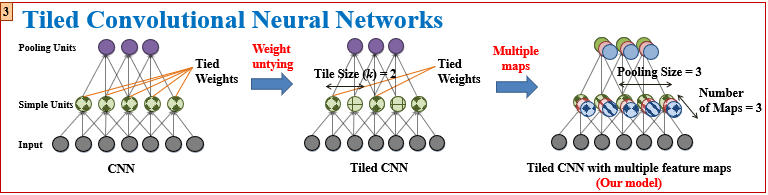 (https://cs.stanford.edu/~quocle/TCNNweb/nips_tcnn_poster.ppt), I opt to use simple CNNs here and save Tiled CNNs for future work.

### Gramian Angular Summation/Difference Fields



[A great article I found explaining gramian angular fields](https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3)

I will attempt to explain the encoding in my own words, however many of my supporting images are from the link above.

Just like we can encode complex numbers in a polar coordinate domain using magnitude and angle to represent real and imaginary pars of the number, we use a polar representation to encode our time series. 
We can express the magnitude *r* and angle *phi* as shown below:
<img src="https://miro.medium.com/max/370/1*_E5pxbxn6BlXBxcQZB7NSw.png" width="100"/>
where the magnitude of the polar domain corresponds to the timesteps of the timeseries and the angle of the polar domain corresponds nonlinearly to the magnitude of the timeseries. [2]

<img src="https://miro.medium.com/max/633/1*5Q2XaC-BqDimZ-2TKz9mbg.png" width="400"/>
We can then utilize the angular component of the polar coordinate system to learn about the temporal correlation between different time intervals. This is called the Gram matrix and can be displayed as an 2D image.  

Basically the diagonal of the matrix can be considered the time, with top left being the start of the timeseries and bottom right being the end. **This can essentially be considered a temporal correlation matrix of the timeseries.** 

GADF is used in [1] as an additional encoding of the timeseries. This is essentially the same GAF encoding explained above, except using a sin difference in the Gram matrix instead of a cos summation. This essentially creates an inverse mapping of the GASF encoding. 

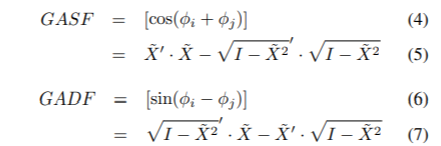 (from [1])

In [ ]:
# Math
import math
import numpy as np

# Tools
def tabulate(x, y, f):
    """Return a table of f(x, y). Useful for the Gram-like operations."""
    return np.vectorize(f)(*np.meshgrid(x, y, sparse=True))

def cos_sum(a, b):
    """To work with tabulate."""
    return(math.cos(a+b))

def sin_diff(a, b):
    """To work with tabulate."""
    return(math.sin(a-b))

def create_time_serie(size, time):
    """Generate a time serie of length size and dynamic with respect to time."""
    # Generating time-series
    support = np.arange(0, size)
    serie = np.cos(support + float(time))
    return(t, serie)

In [ ]:
# Math
import math
import numpy as np

class GASF:

    def __init__(self):
        pass
    def transform(self, serie):
        """Compute the Gramian Angular Field of an image"""
        # Min-Max scaling
        min_ = np.amin(serie)
        max_ = np.amax(serie)
        scaled_serie = (2*serie - max_ - min_)/(max_ - min_)

        # Floating point inaccuracy!
        scaled_serie = np.where(scaled_serie >= 1., 1., scaled_serie)
        scaled_serie = np.where(scaled_serie <= -1., -1., scaled_serie)

        # Polar encoding
        phi = np.arccos(scaled_serie)
        # Note! The computation of r is not necessary
        r = np.linspace(0, 1, len(scaled_serie))

        # GAF Computation (every term of the matrix)
        gaf = tabulate(phi, phi, cos_sum)

        return(gaf, phi, r, scaled_serie)
    
class GADF:

    def __init__(self):
        pass
    def transform(self, serie):
        """Compute the Gramian Angular Field of an image"""
        # Min-Max scaling
        min_ = np.amin(serie)
        max_ = np.amax(serie)
        scaled_serie = (2*serie - max_ - min_)/(max_ - min_)

        # Floating point inaccuracy!
        scaled_serie = np.where(scaled_serie >= 1., 1., scaled_serie)
        scaled_serie = np.where(scaled_serie <= -1., -1., scaled_serie)

        # Polar encoding
        phi = np.arccos(scaled_serie)
        # Note! The computation of r is not necessary
        r = np.linspace(0, 1, len(scaled_serie))

        # GAF Computation (every term of the matrix)
        gaf = tabulate(phi, phi, sin_diff)

        return(gaf, phi, r, scaled_serie)

Implementation from: https://github.com/devitrylouis/imaging_time_series

In [ ]:
gasf = GASF()
gadf = GADF()

In [ ]:
x_train2 = X_train.reshape(2403,187)
x_valid2 = X_valid.reshape(802,187)

Convert training and validation timeseries data into GASF/GADF encodings

In [ ]:
x_train_gasf_images = np.zeros((2403,187,187))
counter = 0
for i in x_train2:
    img = gasf.transform(i)
    x_train_gasf_images[counter] = img[0]
    counter = counter + 1

In [ ]:
x_train_gadf_images = np.zeros((2403,187,187))
counter = 0
for i in x_train2:
    img = gadf.transform(i)
    x_train_gadf_images[counter] = img[0]
    counter = counter + 1

In [ ]:
x_valid_gasf_images = np.zeros((802,187,187))
counter2 = 0
for i in x_valid2:
    img = gasf.transform(i)
    x_valid_gasf_images[counter2] = img[0]
    counter2 = counter2 + 1


In [ ]:
x_valid_gadf_images = np.zeros((802,187,187))
counter2 = 0
for i in x_valid2:
    img = gadf.transform(i)
    x_valid_gadf_images[counter2] = img[0]
    counter2 = counter2 + 1

In [ ]:
print(x_train_gasf_images.shape)
print(x_valid_gasf_images.shape)
print(x_train_gadf_images.shape)
print(x_valid_gadf_images.shape)

So now each entry of our training and validation sets are 187x187 2D images instead of 1D 187 length timeseries.

The third type of encoding, Markov Transition Fields bin the possible values the timeseries can take on as states in a Markov Chain, then use the timeseries data to construct a Markov Transition Matrix (probability of transitioning between states- or for our case probability that time series moves to different bins of magnitude). This is transformed into a Markov Transition Field by spreading out matrix values and considering the temporal positions of the bins. 

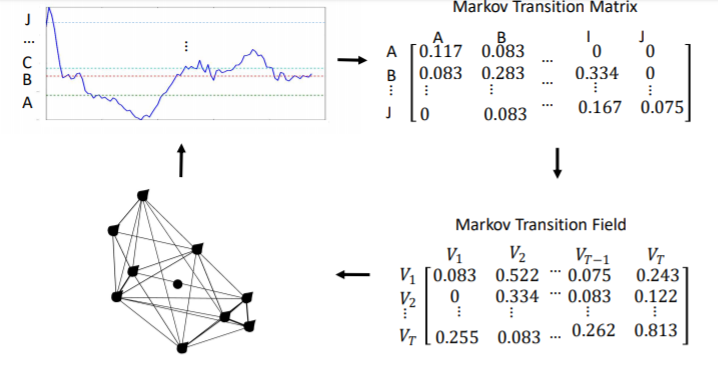
https://arxiv.org/pdf/1610.07273.pdf

So basically the MTF image can be considered dynamic information about the timeseries, and what amplitudes the waveform is at a given temporal location.

In [ ]:
!pip install git+https://github.com/johannfaouzi/pyts.git

In [ ]:
import matplotlib.pyplot as plt
from pyts.image import MarkovTransitionField
from pyts.datasets import load_gunpoint

In [ ]:
print(np.transpose(x_train2[0].reshape(-1,1)).shape)
print(X_train[0,:,:].shape)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

mtf = MarkovTransitionField(image_size=187)
x_train_mtf_images = np.zeros((2403,187,187))
counter = 0
for i in x_train2:
    img = mtf.fit_transform(np.transpose(i.reshape(-1,1)))
    x_train_mtf_images[counter] = img[0]
    counter = counter + 1

In [ ]:
import warnings
warnings.filterwarnings("ignore")

mtf = MarkovTransitionField(image_size=187)
x_valid_mtf_images = np.zeros((802,187,187))
counter = 0
for i in x_valid2:
    img = mtf.fit_transform(np.transpose(i.reshape(-1,1)))
    x_valid_mtf_images[counter] = img[0]
    counter = counter + 1

We remake the plots of different class heartbeats earlier in the notebook as a plot of different encoded images. 

(I just hardcoded indeces that had examples of each class) Sorry!

In [ ]:
print(Y_train[512])
print(Y_train[67])
print(Y_train[55])
print(Y_train[9])
print(Y_train[77])

In [ ]:
f, axs = plt.subplots(5,4,figsize=(10,10))


plt.subplot(5,4,1)
plt.ylabel("Normal")
plt.plot(X_train[512])
plt.subplot(5,4,2)
plt.imshow(x_train_gasf_images[512])
plt.subplot(5,4,3)
plt.imshow(x_train_gadf_images[512])
plt.subplot(5,4,4)
plt.imshow(x_train_mtf_images[512])

plt.subplot(5,4,5)
plt.ylabel("Supraventricular Premature")
plt.plot(X_train[67])
plt.subplot(5,4,6)
plt.imshow(x_train_gasf_images[67])
plt.subplot(5,4,7)
plt.imshow(x_train_gadf_images[67])
plt.subplot(5,4,8)
plt.imshow(x_train_mtf_images[67])

plt.subplot(5,4,9)
plt.ylabel("Premature VC")
plt.plot(X_train[55])
plt.subplot(5,4,10)
plt.imshow(x_train_gasf_images[55])
plt.subplot(5,4,11)
plt.imshow(x_train_gadf_images[55])
plt.subplot(5,4,12)
plt.imshow(x_train_mtf_images[55])

plt.subplot(5,4,13)
plt.ylabel("Fusion")
plt.plot(X_train[9])
plt.subplot(5,4,14)
plt.imshow(x_train_gasf_images[9])
plt.subplot(5,4,15)
plt.imshow(x_train_gadf_images[9])
plt.subplot(5,4,16)
plt.imshow(x_train_mtf_images[9])

plt.subplot(5,4,17)
plt.xlabel("Timeseries")
plt.ylabel("Unclassifiable Beat")
plt.plot(X_train[77])
plt.subplot(5,4,18)
plt.xlabel("GASF")
plt.imshow(x_train_gasf_images[77])
plt.subplot(5,4,19)
plt.xlabel("GADF")
plt.imshow(x_train_gadf_images[77])
plt.subplot(5,4,20)
plt.xlabel("MTF")
plt.imshow(x_train_mtf_images[77])



https://arxiv.org/pdf/1506.00327.pdf considers a GASF- GADF- MTF compound image (1 for each channel like RGB), then we can feed the 3 channel compound into a CNN

> Note that at each pixel, Gij denotes the superstition/difference of the directions at ti and tj , Mij is the transition probability from the quantile at ti
to the quantile at tj .
GAF encodes static information while MTF depicts information about dynamics. From this point of view, we consider
them as three “orthogonal” channels, like different colors in
the RGB image space. Thus, we can combine GAFs and MTF
images of the same size (i.e. SGAF s = SMT F ) to construct a
triple-channel image (GASF-GADF-MTF). It combines both
the static and dynamic statistics embedded in the raw time
series, and we posit that it will be able to enhance classification performance

In [ ]:
x_train_new = np.concatenate((np.expand_dims(x_train_gasf_images, axis=3),np.expand_dims(x_train_gadf_images, axis=3), np.expand_dims(x_train_mtf_images, axis=3)), axis=3)

Now we have successfully converted our testing and validation time series data into encoded images. Let's try transfer learning with a powerful CNN to see if we can better predict heartbeat classification

In [ ]:
print(x_train_gasf_images.shape)
print(x_train_gadf_images.shape)
print(x_train_mtf_images.shape)
print(x_train_new.shape)

In [ ]:
x_valid_new = np.concatenate((np.expand_dims(x_valid_gasf_images, axis=3),np.expand_dims(x_valid_gadf_images, axis=3), np.expand_dims(x_valid_mtf_images, axis=3)), axis=3)

In [ ]:
print(x_valid_gasf_images.shape)
print(x_valid_gadf_images.shape)
print(x_valid_mtf_images.shape)
print(x_valid_new.shape)

# Transfer learning from RESNET50

First we try a transfer learning approach using RESNET50. Transfer learning allows us to utilize state of the art networks that have been trained and tuned on large amounts of data for long periods of time. RESNET50 is a convolutional neural network that has been used to classify images in the IMAGENET competetion. We import RESNET50 architecture from Keras library without the final output layer and add a custom Dense output layer to represent our 5 arrythmia classes.

In [ ]:
from keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

In [ ]:
from keras.layers import *
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50

CLASS_COUNT = 5

base_model = ResNet50(
    weights='imagenet',
    include_top=False, 
    input_shape=(187, 187, 3), 
    pooling='avg',
)
base_model.trainable = False

model = Sequential([
  base_model,
  Dense(CLASS_COUNT, activation='softmax'),
])

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print("training")
print(x_train_new.shape)
print(Y_train.shape)
print("validation")
print(x_valid_new.shape)
print(Y_valid.shape)

In [ ]:
#train the model
history = model.fit(x_train_new, Y_train, validation_data=(x_valid_new, Y_valid), epochs=10)

In [ ]:
plot_model_history(history)

This seems to vastly overfit on the training set...

We try a simple CNN now...

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, kernel_size=3, activation='softmax', input_shape=(187,187,3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, kernel_size=3, activation='softmax'))
model.add(Dropout(0.2))
model.add(MaxPool2D(pool_size = (2, 2)))


model.add(Flatten())
model.add(Dense(5, activation='softmax'))

#compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#train the model
history = model.fit(x_train_new, Y_train, validation_data=(x_valid_new, Y_valid), epochs=15)

In [ ]:
plot_model_history(history)

The training and testing accuracy ends up similar to the naive LSTM network. Perhaps hyperparameter optimization of the neural network is needed to increase accuracy.

**Todo: Hyperparameter optimization? (activation function, architecture) Data Augmentation? Maybe try above with non-downsampled data (at least 10x training data points) **

# Final Thoughts

*Transfer learning via RESNET50 was attempted but massively overfit on the validation set. A simple convolutionual NN from Keras seemed to perform better on validation data than the RESNET. Potential future routes of exploration to improve validation accuracy could be [Convolutional LSTM networks](https://papers.nips.cc/paper/5955-convolutional-lstm-network-a-machine-learning-approach-for-precipitation-nowcasting.pdf) (combining RNN and CNN properties), Using Tiled CNNs as in the [original image encoding paper](https://aaai.org/ocs/index.php/WS/AAAIW15/paper/viewFile/10179/10251), or exploring state of the art TSC networks such as [InceptionTime](https://arxiv.org/pdf/1909.04939v2.pdf), a TSC equivalent of AlexNet. *